# **DataScience Project on Rice Leaf Disease clasification using CNN** 

# Problem statement
To prepare a complete data analysis report on the given data.

To create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot.

Analyze various techniques like Data Augmentation etc and create a report on that.

## Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### setting constants

In [2]:
IMAGE_SIZE=224
BATCH_SIZE=10
channels=3
epochs = 80

## Importing data into tensorflow dataset object

In [3]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"D:\CDS Project file\PRCP-1001-RiceLeaf\Data"
,
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)

Found 119 files belonging to 3 classes.


## Domain Analysis

 Rice is one of the most important crops worldwide, providing sustenance to over half of the world's population. However, rice plants are vulnerable to several diseases that can severely impact the yield and quality of rice production. Some of the major rice diseases that affect rice plants include bacterial leaf blight, brown spot, and leaf smut.
This dataset contains 120 jpg images of disease-infected rice leaves. The images are grouped into 3 classes based on the type of disease. There are 40 images in each class.

Classes are:

● Leaf smut
● Brown spot
● Bacterial leaf blight

Leaf smut caused by the fungus Entyloma oryzae, is a relatively less common rice disease. The symptoms of leaf smut include the formation of small, round, and reddish-brown spots on the leaves. These spots later turn black and produce powdery spores. Although leaf smut does not usually cause significant yield losses, it can affect the quality of rice grains by reducing their weight and size .

Brown spot, caused by the fungus Cochliobolus miyabeanus, is another major rice disease that can cause significant yield losses. The disease is characterized by small, oval to elliptical spots on the leaves, which turn brown with a yellow halo. In severe cases, the spots can coalesce and cause the leaves to wither and die. Brown spot can also affect the panicles, leading to a reduction in grain quality and yield .

Bacterial leaf blight, caused by the bacterium Xanthomonas oryzae pv. oryzae, is a serious disease that can cause extensive damage to rice plants. The symptoms of bacterial leaf blight include water-soaked lesions on the leaves, which later turn brown and dry up. In severe cases, the disease can cause wilting and death of the plant, leading to a significant reduction in crop yield .

#### Class name

In [4]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(10, 224, 224, 3)
[2 2 0 1 2 1 2 1 1 2]


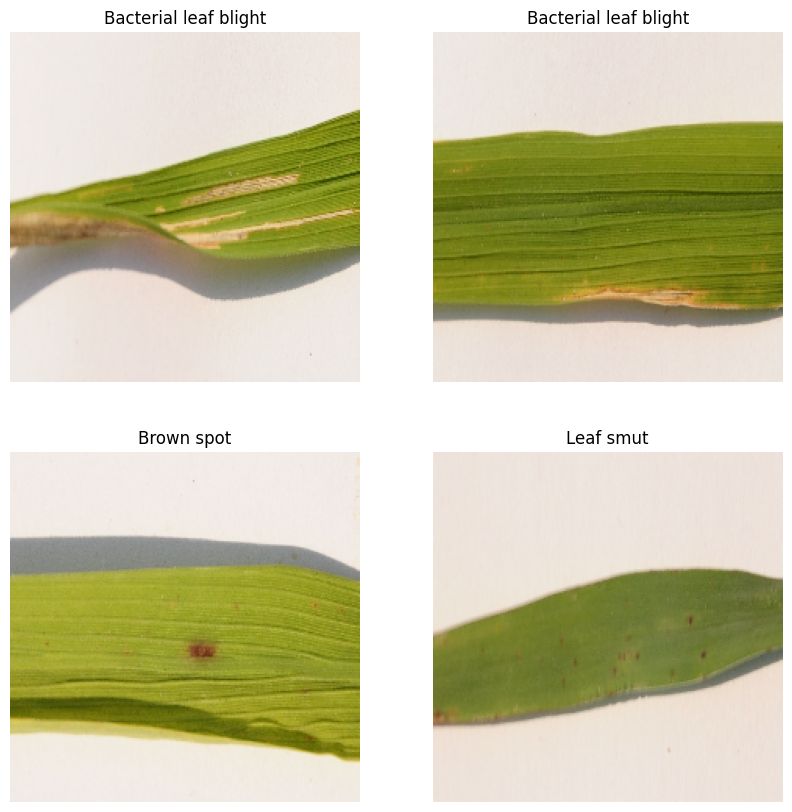

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

## Split the data for training ,testing and validation

In [7]:
def get_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = 8
    val_size = 2
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [8]:
train_ds,val_ds,test_ds = get_partition_tf(dataset)

In [9]:
len(test_ds)

2

In [10]:
len(train_ds)

8

In [11]:
len(val_ds)

2

### Improve the model perfomance

1. Caching: cache() stores the dataset in memory, allowing for faster access to the data during training. This is particularly useful when working with large datasets that don't fit in memory.

2. Shuffling: shuffle(1000) randomizes the order of the data in the dataset. This is important for several reasons:
   
    - Prevents overfitting: By shuffling the data, you ensure that the model sees a different order of examples during each epoch, which helps prevent overfitting.
    - Improves model robustness: Shuffling helps the model learn to generalize better by seeing different examples in different orders.
      
3. Prefetching: prefetch(buffer_size=tf.data.AUTOTUNE) allows the dataset to prefetch batches of data into memory before they are actually needed. This can significantly speed up training by reducing the time spent waiting for data to be loaded.


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## creating a layers for resize and normalization of the dataset

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

# Data Agumentation

Data augmentation is a technique used to increase the size and diversity of a dataset by applying various transformations to the existing data. This technique has become an essential tool in computer vision and image processing tasks, such as object recognition and classification, due to its ability to enhance the generalization ability of machine learning models and prevent overfitting.



In [14]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Building

In [16]:
# Basic CNN model without extra layers for debugging
input_shape = (224, 224, 3)  # Shape of a single input sample
n_classes = 3  # Number of classes

model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,171 (637.39 KB)

 Trainable params: 163,171 (637.39 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(train_ds,epochs=100,batch_size=BATCH_SIZE,verbose=1,
         validation_data=val_ds)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 601ms/step - accuracy: 0.3126 - loss: 21.0206 - val_accuracy: 0.4500 - val_loss: 3.5447
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.4131 - loss: 4.2309 - val_accuracy: 0.3000 - val_loss: 1.2183
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.4996 - loss: 1.2782 - val_accuracy: 0.4500 - val_loss: 1.1108
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.4460 - loss: 1.1334 - val_accuracy: 0.3000 - val_loss: 1.1357
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.5015 - loss: 0.9881 - val_accuracy: 0.4500 - val_loss: 0.9924
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - accuracy: 0.4476 - loss: 1.0653 - val_accuracy: 0.5500 - val_loss: 0.9331
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.4812 - loss: 1.0244 - val_accuracy: 0.4500 - val_loss: 1.0122
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.3970 - loss: 0.9990 - val_accuracy: 0.6500 -

In [18]:
score = model.evaluate(test_ds)
score

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 0.1185


[0.14118686318397522, 1.0]

## Prediction on Sample image

first image to predict
actual label: Leaf smut
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
predicted label: Leaf smut


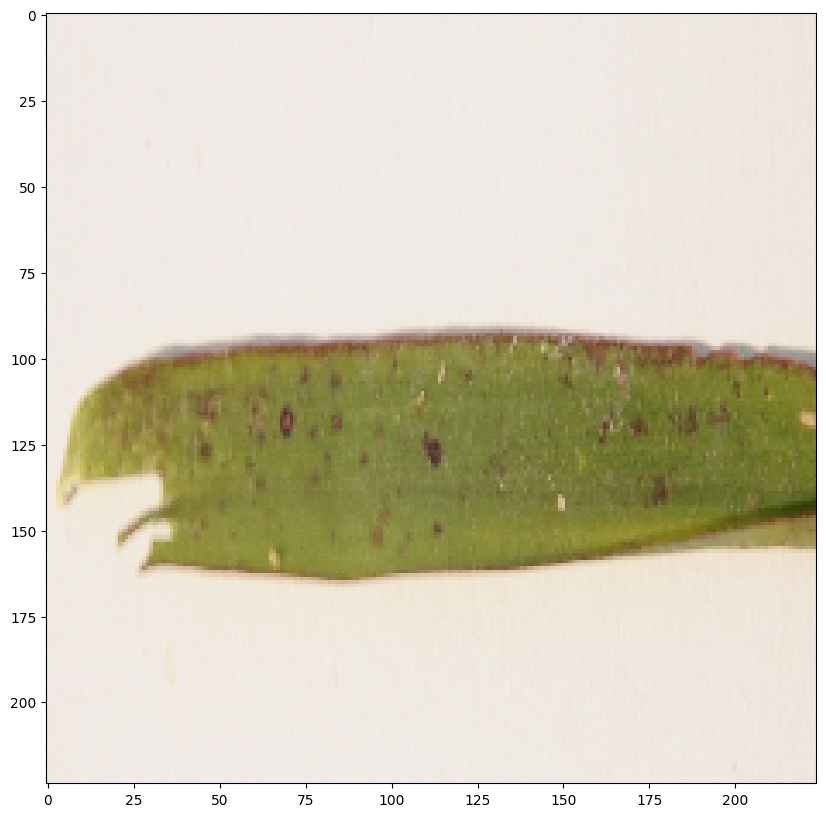

In [19]:
plt.figure(figsize=(10,10))
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Creating function

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Prediction

In [21]:
import numpy as np

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


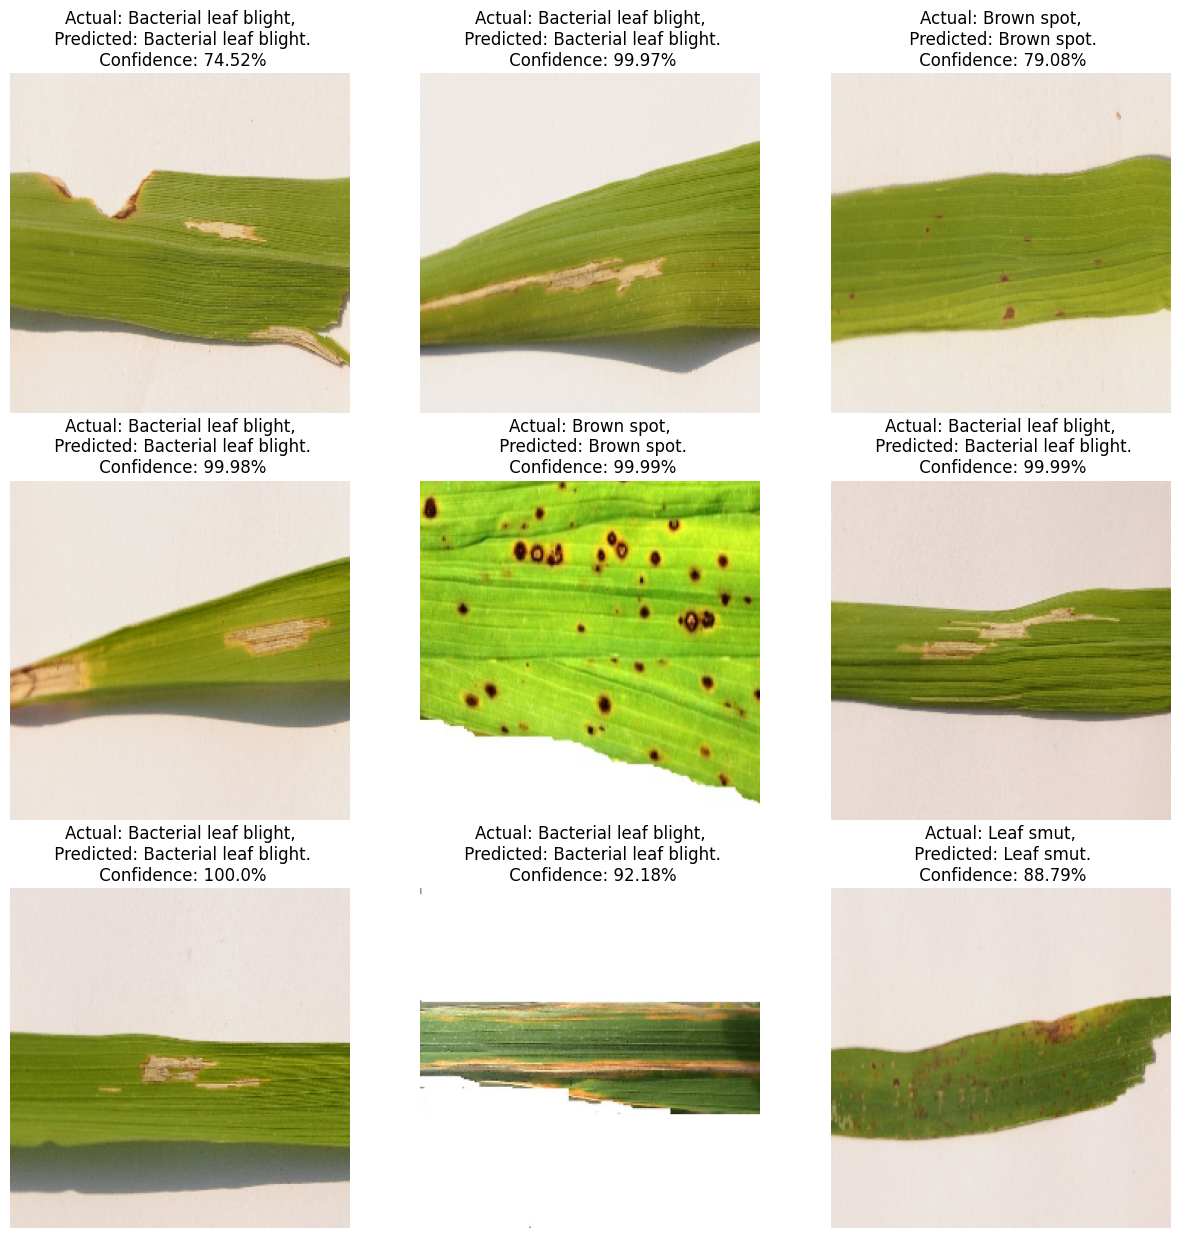

In [22]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Problem faced

* We have less numbers of data which make to loose in training acuuracy.
* Dataset loading will take little more time.
  

## **Using Pretrained Model**

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load MobileNetV2 without the top layer
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Apply pooling
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Add dropout for regularization
x = Dense(64, activation='relu')(x)  # Another dense layer

output_layer = Dense(3, activation='softmax')(x)  # Connect output properly!

# Create final model
model = Model(inputs=base_model.input, outputs=output_layer)  # ✅ Connect output layer properly

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,430,403 (9.27 MB)

 Trainable params: 172,419 (673.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 769ms/step - accuracy: 0.2857 - loss: 1.1511 - val_accuracy: 0.7000 - val_loss: 0.9733
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - accuracy: 0.5212 - loss: 0.9760 - val_accuracy: 0.6000 - val_loss: 0.8894
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.4409 - loss: 1.0544 - val_accuracy: 0.6500 - val_loss: 0.8538
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.6622 - loss: 0.8154 - val_accuracy: 0.7500 - val_loss: 0.7880
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - accuracy: 0.4563 - loss: 1.0843 - val_accuracy: 0.6000 - val_loss: 0.7809
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.6487 - loss: 0.8022 - val_accuracy: 0.6500 - val_loss: 0.7375
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.5824 - loss: 0.8868 - val_accuracy: 0.6500 - val_loss: 0.7278
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.5805 - loss: 0.8822 - val_accuracy: 0.6500 - val_loss

## **Fine-Tune MobileNetV2 for Higher Accuracy**

In [26]:
# Unfreeze the last few layers of MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:100]:  # Keep first 100 layers frozen
    layer.trainable = False

# Recompile and retrain with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 921ms/step - accuracy: 0.3674 - loss: 1.6484 - val_accuracy: 0.6500 - val_loss: 0.7155
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 497ms/step - accuracy: 0.3221 - loss: 2.0146 - val_accuracy: 0.6000 - val_loss: 0.7173
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - accuracy: 0.4708 - loss: 1.4231 - val_accuracy: 0.6000 - val_loss: 0.7199
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 501ms/step - accuracy: 0.4742 - loss: 1.4202 - val_accuracy: 0.5500 - val_loss: 0.7237
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 488ms/step - accuracy: 0.4117 - loss: 1.3393 - val_accuracy: 0.5500 - val_loss: 0.7328


## **save file**

In [28]:
model.save("rice_leaf_mobilenet.h5")
